# What resolution do we need to measure P(vparallel| rparallel, rperp) ? 

Test tpcf(sperp, spar) to tpcf(s, mu) mapping and accuracy on multipoles (or wedges)


In [113]:
from halotools.mock_observables import rp_pi_tpcf, tpcf, s_mu_tpcf, tpcf_multipole
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import pickle
from CentralStreamingModel.utils.read_probabilities import VD_los
from CentralStreamingModel.integral.real2redshift import compute_integrand, integrate
import tpcf_tools as tt
import seaborn as sns
import CentralStreamingModel.comparisons.models as md

sns.set_context('talk')

In [3]:
def pi_sigma2s_mu(s_center, pi_sigma, s_bins_center, mu_bins_center):

    s_mu = np.zeros((s_bins_center.shape[0], mu_bins_center.shape[0]))
    pi_sigma_interpolation = interp2d(s_center, s_center, pi_sigma, kind='linear')

    for i,s in enumerate(s_bins_center):
        for j,mu in enumerate(mu_bins_center):
            r_parallel = mu * s 
            r_perpendicular = np.sqrt(s**2 - r_parallel**2)

            s_mu[i,j] = pi_sigma_interpolation(r_parallel, r_perpendicular)

    return s_mu 
      
def get_multipoles(s, pi_sigma, s_bins, mu_bins):

    s_center = 0.5*(s[1:] + s[:-1])
    s_bins_center = 0.5*(s_bins[1:] + s_bins[:-1])

    mu_bins_center = 0.5*(mu_bins[1:] + mu_bins[:-1])
    
    s_mu = pi_sigma2s_mu(s_center, pi_sigma, s_bins_center, mu_bins_center)

    mono = tpcf_multipole(s_mu, mu_bins, order =0) 
    quad = tpcf_multipole(s_mu, mu_bins, order =2) 
    hexa = tpcf_multipole(s_mu, mu_bins, order =4) 

    return s_mu, mono, quad, hexa


In [123]:
snapshot = 11
n_boxes = range(1,15)

box_dicts = []

for i, box in enumerate(n_boxes):
    with open(f"/raid/c-cuesta/tpcfs/redshift/box{100 + box}_s{snapshot:03d}.pickle",
              "rb") as input_file:
        redshift_dict = pickle.load(input_file)
    box_dicts.append(redshift_dict)
    
s_bins_c = redshift_dict['r']


In [69]:
s_bins = np.arange(0., 50.,1)
s_bins[0] += 0.0001


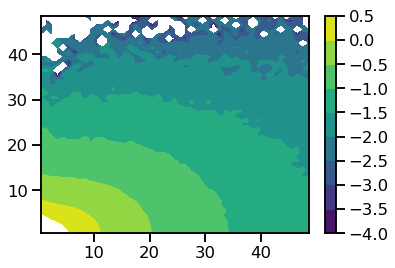

In [98]:
levels = np.arange(-4, 1, 0.5)
plt.contourf(s_bins_c, s_bins_c,
             np.log10(redshift_dict['pi_sigma']).T, levels=levels)
plt.colorbar()

# From pi_sigma to s_mu

In [86]:
import importlib
importlib.reload(tt)

<module 'tpcf_tools' from '/home/c-cuesta/CentralStreamingModel/tpcfs/tpcf_tools.py'>

In [102]:
# Interpolate mean pi sigma 

mean_pi_sigma = np.mean([boxdict['pi_sigma'] for boxdict in box_dicts], axis = 0)
mean_s_mu = np.mean([boxdict['s_mu'] for boxdict in box_dicts], axis = 0)

n_mu_bins = 60
mu_bins = np.linspace(0.,1.,n_mu_bins)
mu_bins_c = 0.5 * (mu_bins[1:] + mu_bins[:-1])
s_mu_interp, mono_interp, quad_interp, hexa_interp =  tt.get_multipoles(s_bins,
                                    mean_pi_sigma,
                                    s_bins, mu_bins)

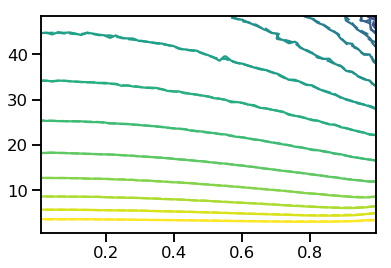

In [103]:
levels = np.arange(-4, 1, 0.3)
plt.contour(mu_bins_c,s_bins_c, np.log10(mean_s_mu),
           levels = levels)
plt.contour(mu_bins_c,s_bins_c, np.log10(s_mu_interp),
           linestyles='dashed', levels = levels)


In [89]:
wedges_interp = tt.get_wedges(s_bins_c, s_mu_interp, mu_bins, wedges_bins)

Text(0, 0.5, '$s^2 \\xi_0(s)$')

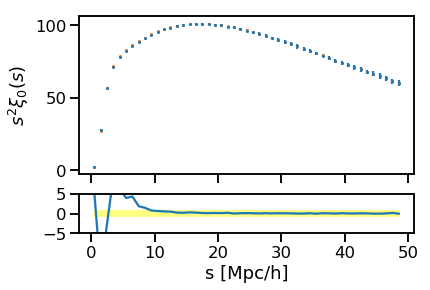

In [110]:
mean_mono = np.mean([boxdict['mono'] for boxdict in box_dicts], axis = 0)
std_mono = np.std([boxdict['mono'] for boxdict in box_dicts], axis = 0)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, 
                squeeze = True, gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_bins_c, s_bins_c * s_bins_c * mean_mono, 
             yerr = s_bins_c * s_bins_c * std_mono,
             label = f'{n_mu_bins} bins in $\mu$',
        linestyle='', marker='o', markersize=2)
ax1.plot(s_bins_c, s_bins_c * s_bins_c *mono_interp,
         linestyle='', marker='o', markersize = 2, label='Interpolated')

ax2.plot(s_bins_c, (mono_interp - mean_mono)/std_mono)
ax2.fill_between(s_bins_c, -1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5.)


#plt.legend()
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(r'$s^2 \xi_0(s)$')

Text(0, 0.5, '$s^2 \\xi_0(s)$')

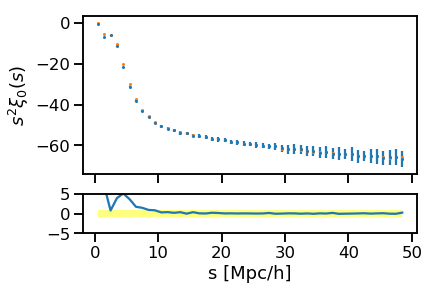

In [111]:
mean_quad = np.mean([boxdict['quad'] for boxdict in box_dicts], axis = 0)
std_quad = np.std([boxdict['quad'] for boxdict in box_dicts], axis = 0)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, 
                squeeze = True, gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_bins_c, s_bins_c * s_bins_c * mean_quad, 
             yerr = s_bins_c * s_bins_c * std_quad,
             label = f'{n_mu_bins} bins in $\mu$',
        linestyle='', marker='o', markersize=2)
ax1.plot(s_bins_c, s_bins_c * s_bins_c *quad_interp,
         linestyle='', marker='o', markersize = 2, label='Interpolated')

ax2.plot(s_bins_c, (quad_interp - mean_quad)/std_quad)
ax2.fill_between(s_bins_c, -1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5.)


#plt.legend()
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(r'$s^2 \xi_0(s)$')

Text(0, 0.5, '$s^2 \\xi_0(s)$')

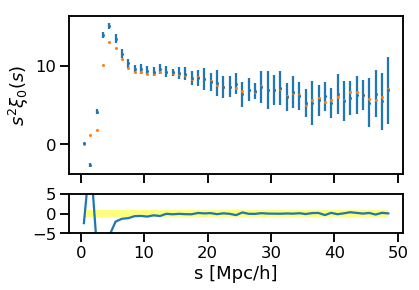

In [112]:
mean_hexa = np.mean([boxdict['hexa'] for boxdict in box_dicts], axis = 0)
std_hexa = np.std([boxdict['hexa'] for boxdict in box_dicts], axis = 0)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, 
                squeeze = True, gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_bins_c, s_bins_c * s_bins_c * mean_hexa, 
             yerr = s_bins_c * s_bins_c * std_hexa,
             label = f'{n_mu_bins} bins in $\mu$',
        linestyle='', marker='o', markersize=2)
ax1.plot(s_bins_c, s_bins_c * s_bins_c *hexa_interp,
         linestyle='', marker='o', markersize = 2, label='Interpolated')

ax2.plot(s_bins_c, (hexa_interp - mean_hexa)/std_hexa)
ax2.fill_between(s_bins_c, -1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5.)


#plt.legend()
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(r'$s^2 \xi_0(s)$')

# Check streaming model with 1 Mpc width is enough

In [114]:
n_boxes = range(1,15)
boxsize = 2000
snapshot = 11

rs = []
for i, box in enumerate(n_boxes):
    rs.append(md.RedshiftSpace(box, boxsize, snapshot))

In [116]:
mean_rs = md.MeanRedshiftSpace( boxsize, snapshot, rs)


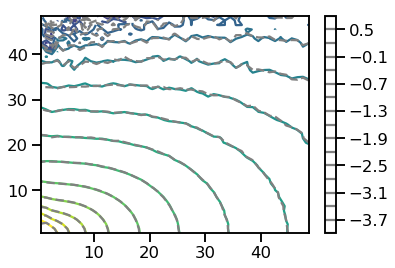

In [126]:
plt.contour(redshift_dict['r'], redshift_dict['r'],
             np.log10(mean_pi_sigma).T, levels=levels)

colors = [mean_rs.streaming.color] * len(levels)
plt.contour(mean_rs.streaming.s_c, mean_rs.streaming.s_c,
            np.log10(mean_rs.streaming.pi_sigma).T,
           levels=levels, colors=colors, linestyles='dashed')

plt.colorbar()

In [128]:
s_mu_interp_stream, mono_interp_stream, quad_interp_stream, hexa_interp_stream =  tt.get_multipoles(mean_rs.streaming.s,
                                                        mean_rs.streaming.pi_sigma,
                                                        s_bins, mu_bins)

Text(0, 0.5, '$s^2 \\xi_0(s)$')

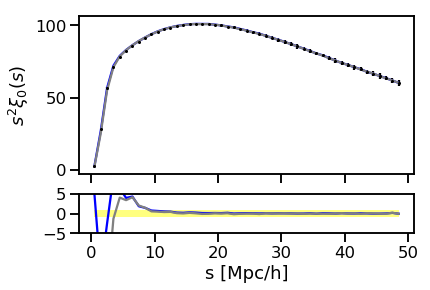

In [130]:
mean_mono = np.mean([boxdict['mono'] for boxdict in box_dicts], axis = 0)
std_mono = np.std([boxdict['mono'] for boxdict in box_dicts], axis = 0)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, 
                squeeze = True, gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_bins_c, s_bins_c * s_bins_c * mean_mono, 
             yerr = s_bins_c * s_bins_c * std_mono,
             label = f'{n_mu_bins} bins in $\mu$',
        linestyle='', marker='o', markersize=2, color='black')
ax1.plot(s_bins_c, s_bins_c * s_bins_c *mono_interp,
         linestyle='-', label='Interpolated', color = 'blue')
ax1.plot(s_bins_c, s_bins_c * s_bins_c *mono_interp_stream,
         linestyle='-', label='Interpolated Stream', color = 'gray')


ax2.plot(s_bins_c, (mono_interp - mean_mono)/std_mono, color = 'blue')

ax2.plot(s_bins_c, (mono_interp_stream - mean_mono)/std_mono, color = 'gray')
ax2.fill_between(s_bins_c, -1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5.)


#plt.legend()
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(r'$s^2 \xi_0(s)$')

Text(0, 0.5, '$s^2 \\xi_0(s)$')

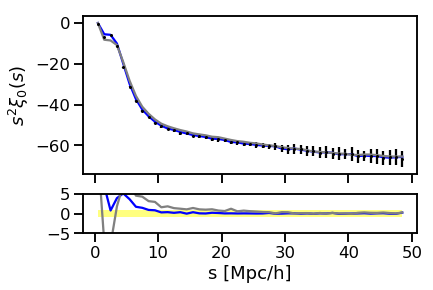

In [131]:
mean_quad = np.mean([boxdict['quad'] for boxdict in box_dicts], axis = 0)
std_quad = np.std([boxdict['quad'] for boxdict in box_dicts], axis = 0)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, 
                squeeze = True, gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_bins_c, s_bins_c * s_bins_c * mean_quad, 
             yerr = s_bins_c * s_bins_c * std_quad,
             label = f'{n_mu_bins} bins in $\mu$',
        linestyle='', marker='o', markersize=2, color='black')
ax1.plot(s_bins_c, s_bins_c * s_bins_c *quad_interp,
         linestyle='-', label='Interpolated', color = 'blue')
ax1.plot(s_bins_c, s_bins_c * s_bins_c *quad_interp_stream,
         linestyle='-', label='Interpolated Stream', color = 'gray')


ax2.plot(s_bins_c, (quad_interp - mean_quad)/std_quad, color = 'blue')

ax2.plot(s_bins_c, (quad_interp_stream - mean_quad)/std_quad, color = 'gray')
ax2.fill_between(s_bins_c, -1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5.)


#plt.legend()
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(r'$s^2 \xi_0(s)$')

Text(0, 0.5, '$s^2 \\xi_0(s)$')

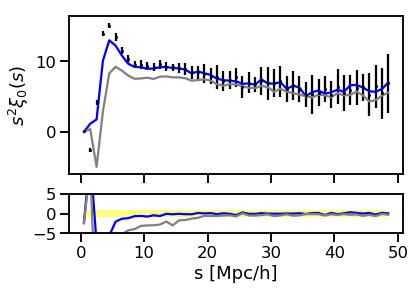

In [132]:
mean_hexa = np.mean([boxdict['hexa'] for boxdict in box_dicts], axis = 0)
std_hexa = np.std([boxdict['hexa'] for boxdict in box_dicts], axis = 0)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, 
                squeeze = True, gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_bins_c, s_bins_c * s_bins_c * mean_hexa, 
             yerr = s_bins_c * s_bins_c * std_hexa,
             label = f'{n_mu_bins} bins in $\mu$',
        linestyle='', marker='o', markersize=2, color='black')
ax1.plot(s_bins_c, s_bins_c * s_bins_c *hexa_interp,
         linestyle='-', label='Interpolated', color = 'blue')
ax1.plot(s_bins_c, s_bins_c * s_bins_c *hexa_interp_stream,
         linestyle='-', label='Interpolated Stream', color = 'gray')


ax2.plot(s_bins_c, (hexa_interp - mean_hexa)/std_hexa, color = 'blue')

ax2.plot(s_bins_c, (hexa_interp_stream - mean_hexa)/std_hexa, color = 'gray')
ax2.fill_between(s_bins_c, -1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5.)


#plt.legend()
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(r'$s^2 \xi_0(s)$')